----------------------------------
# Technovation Montreal
----------------------------------

## Context: 
Learn basis of image classification to show importance of quality and complete data to train a model.

## Data: 
Imat dataset
In this dataset, you are provided a large number of images and corresponding fashion/apparel segmentations. Images are named with a unique ImageId. You must segment and classify the images in the test set. The 2020 version of this dataset uses the same images as the 2019 version, however, the attributes have been relabeled and expanded.

This dataset contains images of people wearing a variety of clothing types in a variety of poses. It may have content that some consider sensitive. Please exercise discretion and maturity when working on the competition.



------------------------
## Concepts to Cover
------------------------
**1. <a href = #link4>Choosing a model</a>**

**2. <a href = #link4>Prepare environment</a>**

**3. <a href = #link5>Train and evaluate the model</a>**


# <a id='link1'>Choosing a model</a>

1.   Identify the type of problem we try to solve with Machine Learning. In our case we need to look for image segmentation models.
2.   Observe the  queantity and quality of the data data we want to use.
3.   If the dataset is comming from a challenge or kaggle competetion, check the most permorming submissions  and the models they used.
3.   Search for existing  models that clearly report their performance and choose the ones that perform the best.
4.   In most cases we cannot use an existing pre trained model, we have to train the model our selfs but we can use an existing architecture with a pretrained encoder. In our case we use Unet and a  pretrained mobilnetv2 encoder:  https://idiotdeveloper.com/unet-segmentation-with-pretrained-mobilenetv2-as-encoder/

*A machine learning model training guideline for beginners: https://towardsdatascience.com/your-complete-guide-to-machine-learning-models-403b4716172c

# <a id='link1'>Prepare Environment</a>

Load data

In [1]:
# Mount your google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd  /content/drive/MyDrive/technovation/

Mounted at /content/drive
/content/drive/MyDrive/technovation


In [ ]:
# Upload kaggle

# from google.colab import files
# files.upload()
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Unzip iMaterialist data

# !pip install kaggle==1.5.8
# !kaggle competitions download -c imaterialist-fashion-2019-FGVC6 -p /content/drive/MyDrive/technovation/
# !unzip /content/drive/MyDrive/technovation/imaterialist-fashion-2019-FGVC6.zip -d /content/drive/MyDrive/technovation/

Install libraries

In [2]:
# Install Libraries
!pip install warmup-scheduler
!pip install pytorch_toolbelt
!pip install scikit-learn
!pip install segmentation_models_pytorch
!pip install albumentations==1.0.3
!pip install opencv-python==4.5.3.56

# <a id='link1'>Train and evaluate the model</a>

Before starting training: 

1.   Adapt your data to the format your machine learning framework can use.
2.   Split your data into train, validation and test dataset.  We will get inference from the test data and tune our model by using the validation.


Loading Data and  transforming them in a format the machine leanring framework can use

In [7]:
import os
import time
import torch
import json
import torchvision
from train import fit
from metrics import dice_with_logits
import cv2
import torch
import torchvision

import pandas as pd
import numpy as np

from PIL import Image
from pytorch_toolbelt import losses as L
from pytorch_toolbelt.utils.rle import rle_encode
from pytorch_toolbelt.utils.rle import rle_decode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import cv2 as cv
import segmentation_models_pytorch as smp

from pathlib import Path
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000
import albumentations as A
from torch.utils.tensorboard import SummaryWriter


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_folder = "./"
train_folder = "./train"

logs_folder ="./logs"
models_folder = "./models"
       

if not Path(logs_folder).exists():
    os.makedirs(logs_folder)

if not Path(models_folder).exists():
    os.makedirs(models_folder)
df = pd.read_csv("./train.csv")

# Get a random 80% of the entire set for training
train_df = df.sample(frac=0.8, random_state=1)

# Get the rest for validation
val_df = df.loc[~df.index.isin(train_df.index)]


with open("./label_descriptions.json") as f:
    label_description = json.load(f)

batch_size = 4
num_workers = 0

# Original samples size 
# train_num_samples = 500
# val_num_samples = 100
# test_num_samples = None

# Demonstration samples size
train_num_samples = 4
val_num_samples = 4
test_num_samples = 4


MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

def image_to_std_tensor(image, **params):
    image = torchvision.transforms.functional.to_tensor(image)
    image = torchvision.transforms.functional.normalize(image, MEAN, STD)
    return image


def mask_to_tensor(mask, **params):
    mask = np.transpose(mask, (2, 0, 1))
    return torch.tensor(mask).long()

custom_to_std_tensor = A.Lambda(image=image_to_std_tensor, mask=mask_to_tensor)

train_transforms = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(),
    A.RandomBrightness(),
    A.RandomContrast(),
    custom_to_std_tensor
])

# Datasets to be contructed for training and validation
datasets = {}


class FashionDataset(torch.utils.data.Dataset):

    def __init__(self, mode, df, folder, transfrom=None, num_samples=None):
        self.mode = mode

        self.df = df
        self.names = df.ImageId.unique().tolist()    
        np.random.shuffle(self.names)

        self.folder = folder
        self.transfrom = transfrom
        self.num_samples = num_samples

    def rle_to_mask(self, item, shape):

        mask = np.zeros((46, 512,512), dtype=int)
        for i in range(0, 46):
            channel = item[item.ClassId == str(i)]

            for j, (_, obj) in enumerate(channel.iterrows()):
                a = rle_decode(obj.EncodedPixels, shape, int)
                a = cv2.resize(a, (512,512), interpolation=cv2.INTER_NEAREST)               
                mask[i] = mask[i] + (a)
        mask = mask.astype(np.uint8)
        mask = np.transpose(mask, (1, 2, 0))
        return mask

    def __getitem__(self, idx):       

        if self.num_samples is not None and self.mode in ["train"]:
            name = np.random.choice(self.names)
        else:
          name = self.names[idx]

        origin_fn = self.folder + '/' + name
       
        print(f"Reading image from : {str(origin_fn)}")
        origin = cv2.imread(str(origin_fn))
        origin_size = origin.shape[:2]
        height = 512
        width = 512
        dim = (width, height)
        origin = cv2.resize(origin, dim, interpolation=cv2.INTER_LINEAR)

        origin = cv2.cvtColor(origin, cv2.COLOR_BGR2RGB)       
        mask = None

        if self.mode in ["train", "val"]:           
            item = self.df[self.df.ImageId == name]
            mask = self.rle_to_mask(item, origin_size)

        if self.transfrom is not None:
            transformed = self.transfrom(
                image=origin,
                mask=mask
            )
            origin = transformed["image"]
            mask = transformed["mask"]

        if mask is None:
            return name, origin
        return name, origin, mask

    def __len__(self):
        if self.num_samples is not None:
            return self.num_samples
        return len(self.names)



datasets["train"] = FashionDataset(
    "train",
    train_df,
    train_folder,
    train_transforms,    
    train_num_samples,
)

datasets["val"] = FashionDataset(
    "val",
    val_df,
    train_folder,
    A.Compose([
        A.Resize(512, 512),
        custom_to_std_tensor
    ]),
    val_num_samples,
)

# Put the datasets to PyTorch dataloaders
dataloaders = {x: torch.utils.data.DataLoader(
    datasets[x],
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
) for x in ["train", "val"]}


class MaskInfo:
    def __init__(self, mask, r=0.0, b=0.0, g=0.0):
        self.value = mask
        self.r = r
        self.g = g
        self.b = b


def blend(origin, *masks, alpha=0.5):
    img = torchvision.transforms.functional.to_pil_image(origin)

    for mask in masks:
        if mask is not None and mask.value is not None and mask.value.sum() != 0.0:
            mask = torchvision.transforms.functional.to_pil_image(torch.cat([
                torch.stack([mask.value.float()]) * mask.r,
                torch.stack([mask.value.float()]) * mask.g,
                torch.stack([mask.value.float()]) * mask.b,
            ]))
            img = Image.blend(img, mask, alpha)

    return img


def denormalize(img_tensor):
    img_tensor = img_tensor.clone()
    for t, m, s in zip(img_tensor, MEAN, STD):
        t.mul_(s).add_(m)
    return img_tensor

# Utility function to visualize images with annotations
def draw(origin, masks, label_description):
    blends = {}
    for i, mask in enumerate(masks):
        if mask.bool().any():
            blends[label_description["categories"][i]["name"]] =\
            blend(denormalize(origin), MaskInfo(mask, g=1.0))

    plt.figure(figsize=(20, 40))
    for i, (name, img) in enumerate(blends.items()):
        plt.subplot(10, 5, i+1)
        plt.title(name)
        plt.imshow(img)
    plt.show() 


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1772: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [ ]:
### Note: this is a debugging block which you can run once to help cv2 finding images from your google drive. 
# Otherwise, communication between colab and google drive can throw you errors while reading images.
# Communication between cv2 and google drive can be established and facilitated with this execution.

from glob import glob
import cv2

def get_all_files_from_folder_with_extension(folder, extension):
    return glob("{}/*.{}".format(folder, extension))


files = get_all_files_from_folder_with_extension("./train",'jpg')
for f in files[:10]:
      f_str = f     
      origin = cv2.imread(f_str)
      origin = cv2.cvtColor(origin, cv2.COLOR_BGR2RGB)    



Examine how segmentation looks on our annotated data

Reading image from : ./train/5d305cabf9eb34d99d9e96dd754ec127.jpg


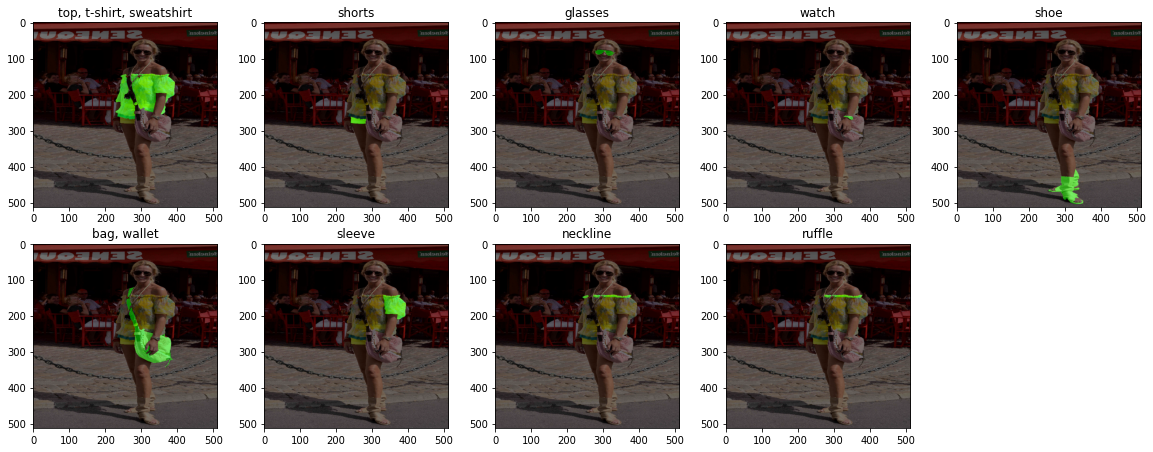

Reading image from : ./train/2cb3469f84a0127a867030437eab0a67.jpg


<Figure size 1440x2880 with 0 Axes>

In [5]:
name, image, mask = datasets["train"][0]
draw(image, mask, label_description)  

# Model Training

In [8]:
segmentation_model = smp.Unet(
    encoder_name="mobilenet_v2",  
    encoder_weights="imagenet",
    classes=46,
    activation=None
)

lr = 0.001

criterion = L.BinaryFocalLoss()
optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=5,
    factor=0.5,
    mode="max"
)

epochs = 2
initial_epoch = 0
accumulation_steps = 1
model_name = "unet-mobilenet-b2-v0"  
writer_folder = logs_folder + '/' + model_name
if not Path(writer_folder).exists():
    os.makedirs(writer_folder)
writer = SummaryWriter(writer_folder)

segmentation_model.to(device)
segmentation_model.train()

fit(
    segmentation_model,
    device,
    criterion,
    optimizer,
    scheduler,
    dataloaders,
    metrics={
        "dice": dice_with_logits
    },
    metrics_monitor="dice", 
    metrics_lower_is_better=False,
    writer=writer,
    writer_add_visualizations=False,
    model_folder=models_folder,
    model_name=model_name,
    remove_previous_ckpt=True,
    epochs=epochs,
    initial_epoch=initial_epoch,
    accumulation_steps=accumulation_steps,
)

epoch: 1/2, train phase:   0%|          | 0/1 [00:00<?, ?it/s]

Reading image from : ./train/2d398837aeb536bcbef40499c0cf5055.jpg
Reading image from : ./train/e7e32c9861e835fb4f73031d60de61dd.jpg
Reading image from : ./train/a4e492e31cd197dcdb4ddfe4f131346d.jpg
Reading image from : ./train/242a2d15149578d329f6c8dc915ddb32.jpg


epoch: 1/2, validation phase:   0%|          | 0/1 [00:00<?, ?it/s]

Reading image from : ./train/31a3b434c5bdce6b87865a6737925707.jpg
Reading image from : ./train/91f10f55419bfdc7fa412a8e4c303f37.jpg
Reading image from : ./train/0234ee456f4ad2dfee4538d98a583d20.jpg
Reading image from : ./train/0e9c219a86c12c3b38d72af6a9779250.jpg


epoch: 1/2, validation phase: 100%|██████████| 1/1 [00:05<00:00,  5.42s/it]


epoch: 1/2, time: 11.08485722541809, train loss: 0.21007132530212402, 
val loss: 2.353766441345215, val_metric: 0.011895398609340191
checkpoint saved



epoch: 2/2, train phase:   0%|          | 0/1 [00:00<?, ?it/s]

Reading image from : ./train/698026393c5baa2397423596a4a4d37e.jpg
Reading image from : ./train/6013914647ce3320f7ced7412951514c.jpg
Reading image from : ./train/bfd31c7b12baebece7af6a376f1903d0.jpg
Reading image from : ./train/ede7f65a115c2be64c0ce2c69620dc34.jpg


epoch: 2/2, validation phase:   0%|          | 0/1 [00:00<?, ?it/s]

Reading image from : ./train/31a3b434c5bdce6b87865a6737925707.jpg
Reading image from : ./train/91f10f55419bfdc7fa412a8e4c303f37.jpg
Reading image from : ./train/0234ee456f4ad2dfee4538d98a583d20.jpg
Reading image from : ./train/0e9c219a86c12c3b38d72af6a9779250.jpg


epoch: 2/2, validation phase: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


epoch: 2/2, time: 16.620157480239868, train loss: 0.18538308143615723, 
val loss: 4.770741939544678, val_metric: 0.017365463078022003
checkpoint saved



## Compare training performance with a model trained using a train size 500 images, validation size 100 image and 2 epocs
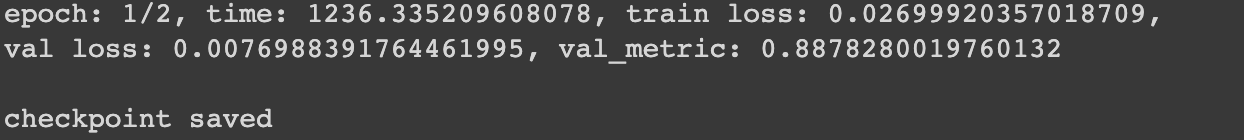
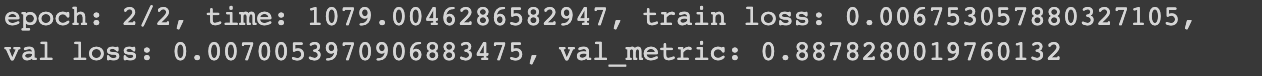

# Model Evaluation
Model inference after 2 epocs using only 4 random images as train, test and validation

Reading image from : ./train/31a3b434c5bdce6b87865a6737925707.jpg


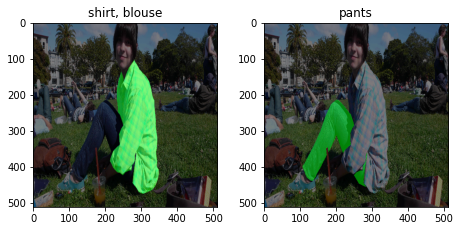

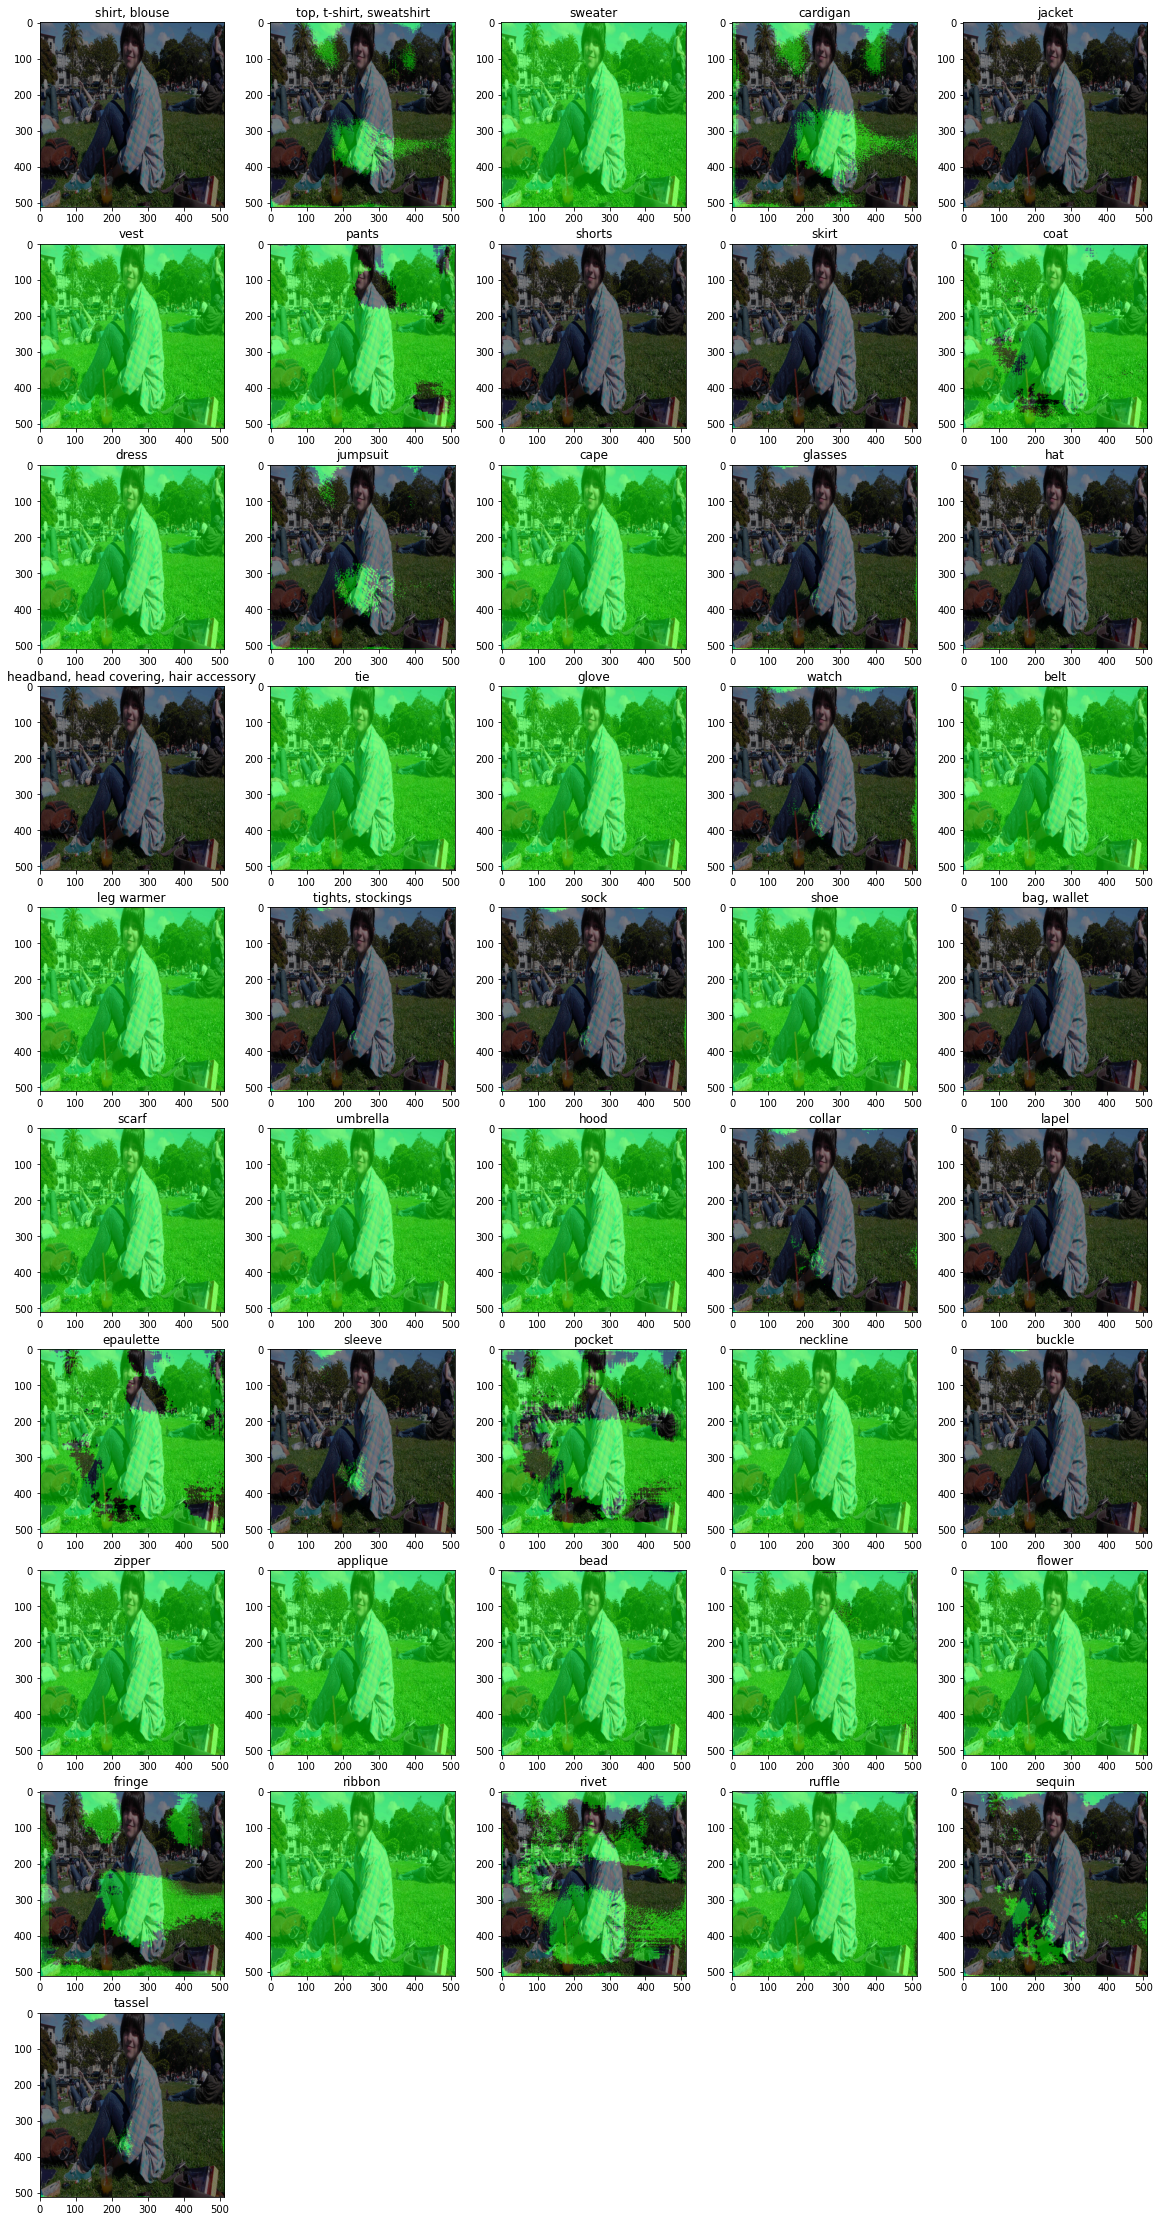

In [9]:
name, image, mask = datasets["val"][0]

images = image.unsqueeze(0)
masks = mask.unsqueeze(0)
images = images.to(device)  
masks = masks.to(device)  

with torch.no_grad():
    segmentation_model.eval()
    outs = segmentation_model(images)
    outs = outs.cpu().detach()


probs = outs.sigmoid()
draw(images[0].cpu(), masks[0].cpu(), label_description)
draw(images[0].cpu(), probs[0].cpu() > 0.3, label_description)


## Model Inferene Using a Pretrained Model
Load an existing model that was trained with 2 epcos using only the first 4 images of the train set, a problem of overfitting.

load model_state_dict
load initial epoch


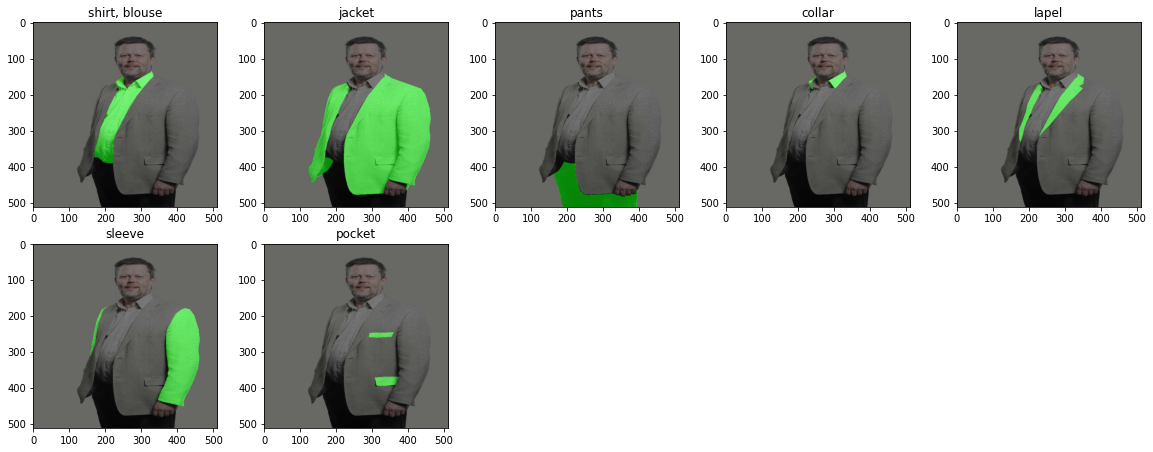

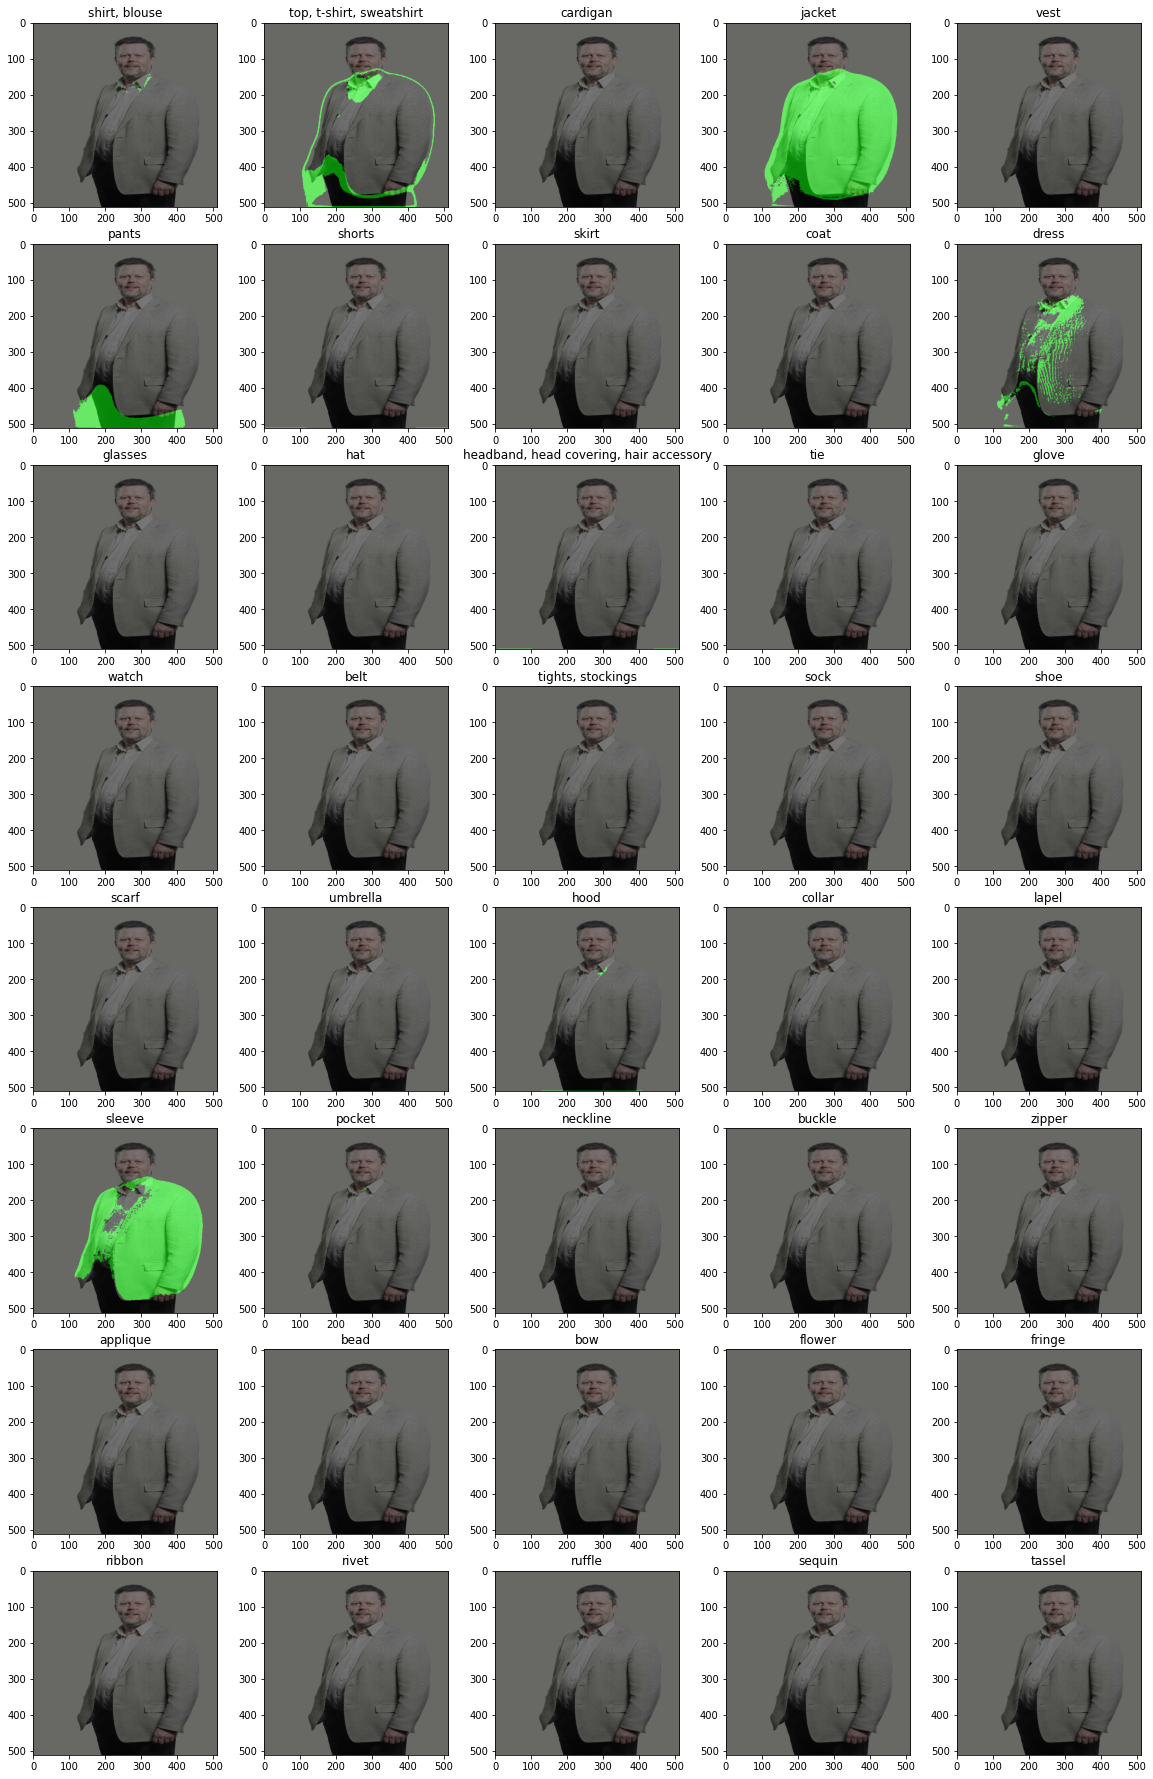

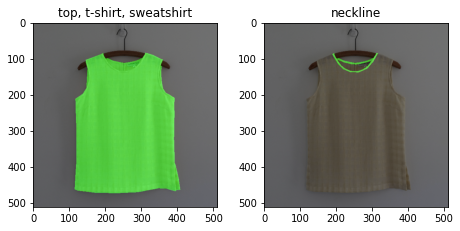

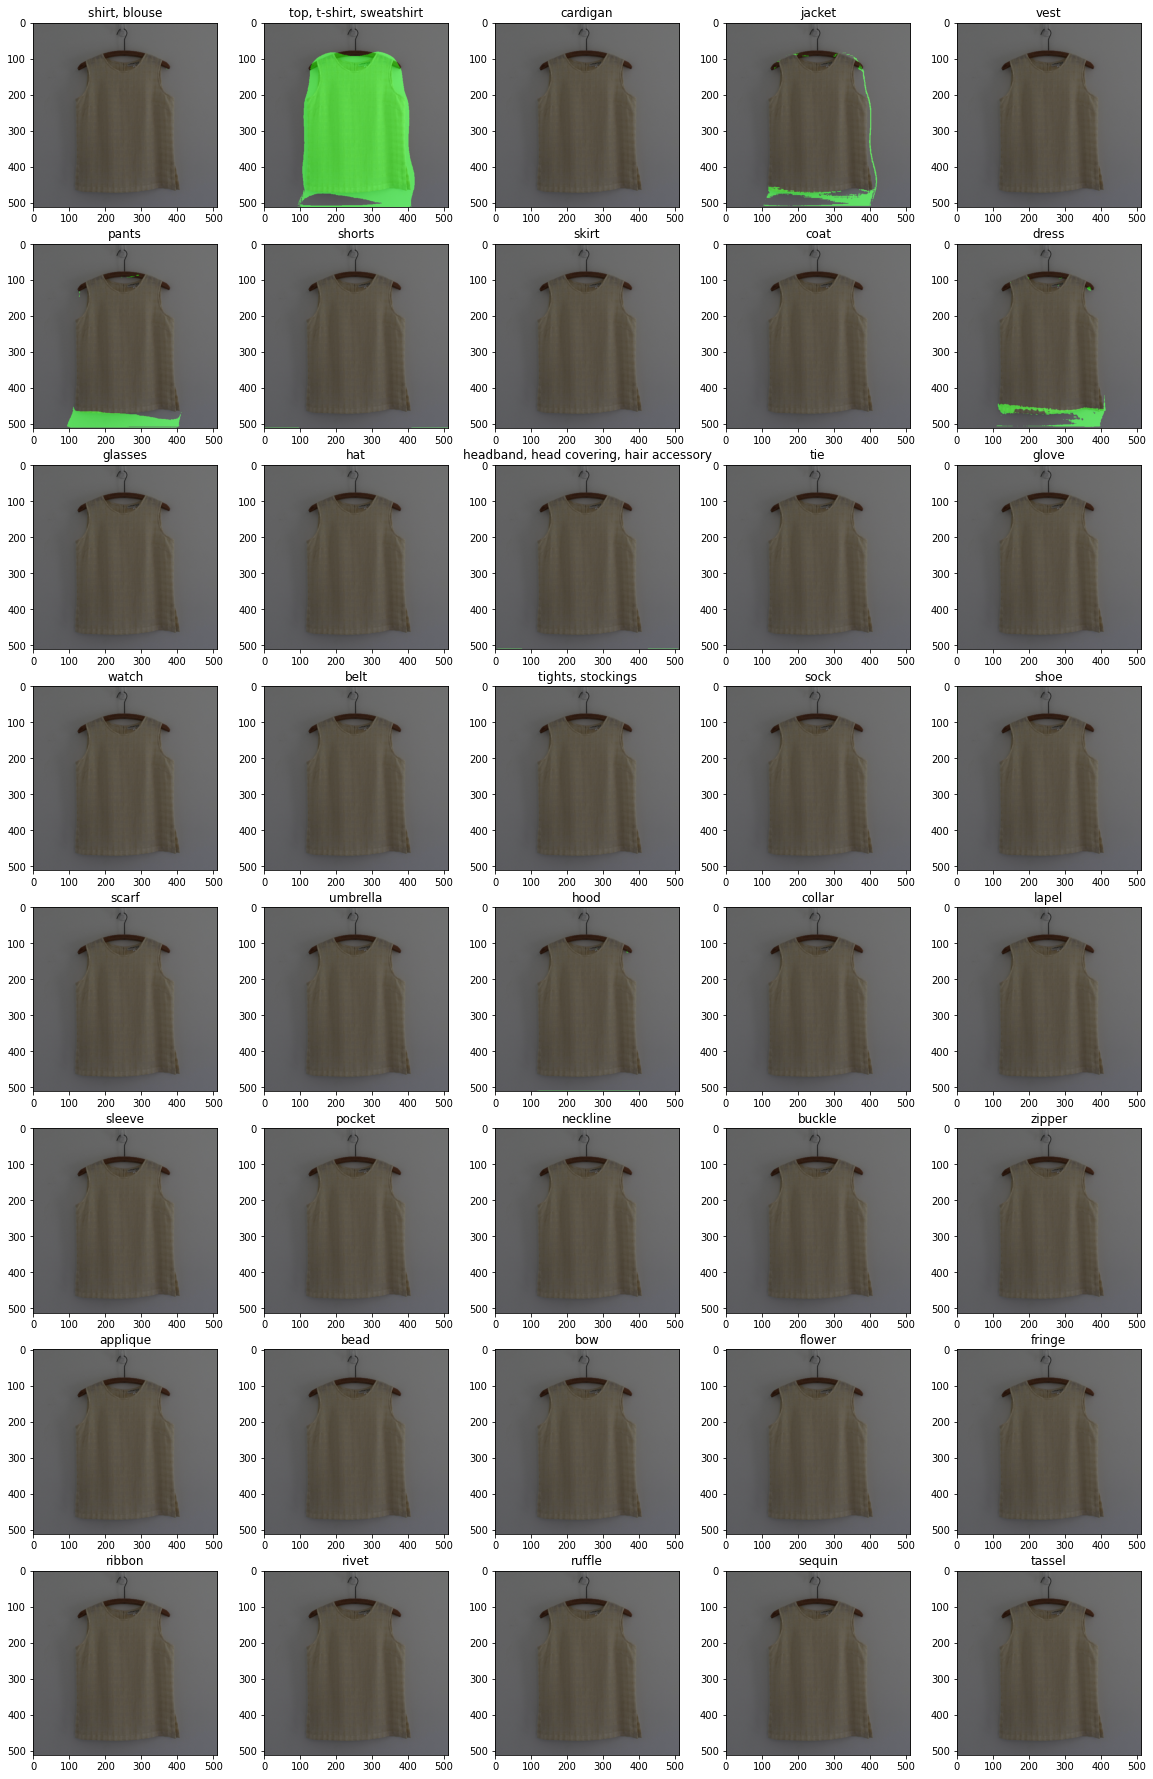

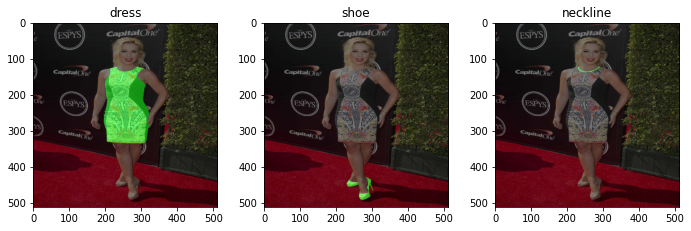

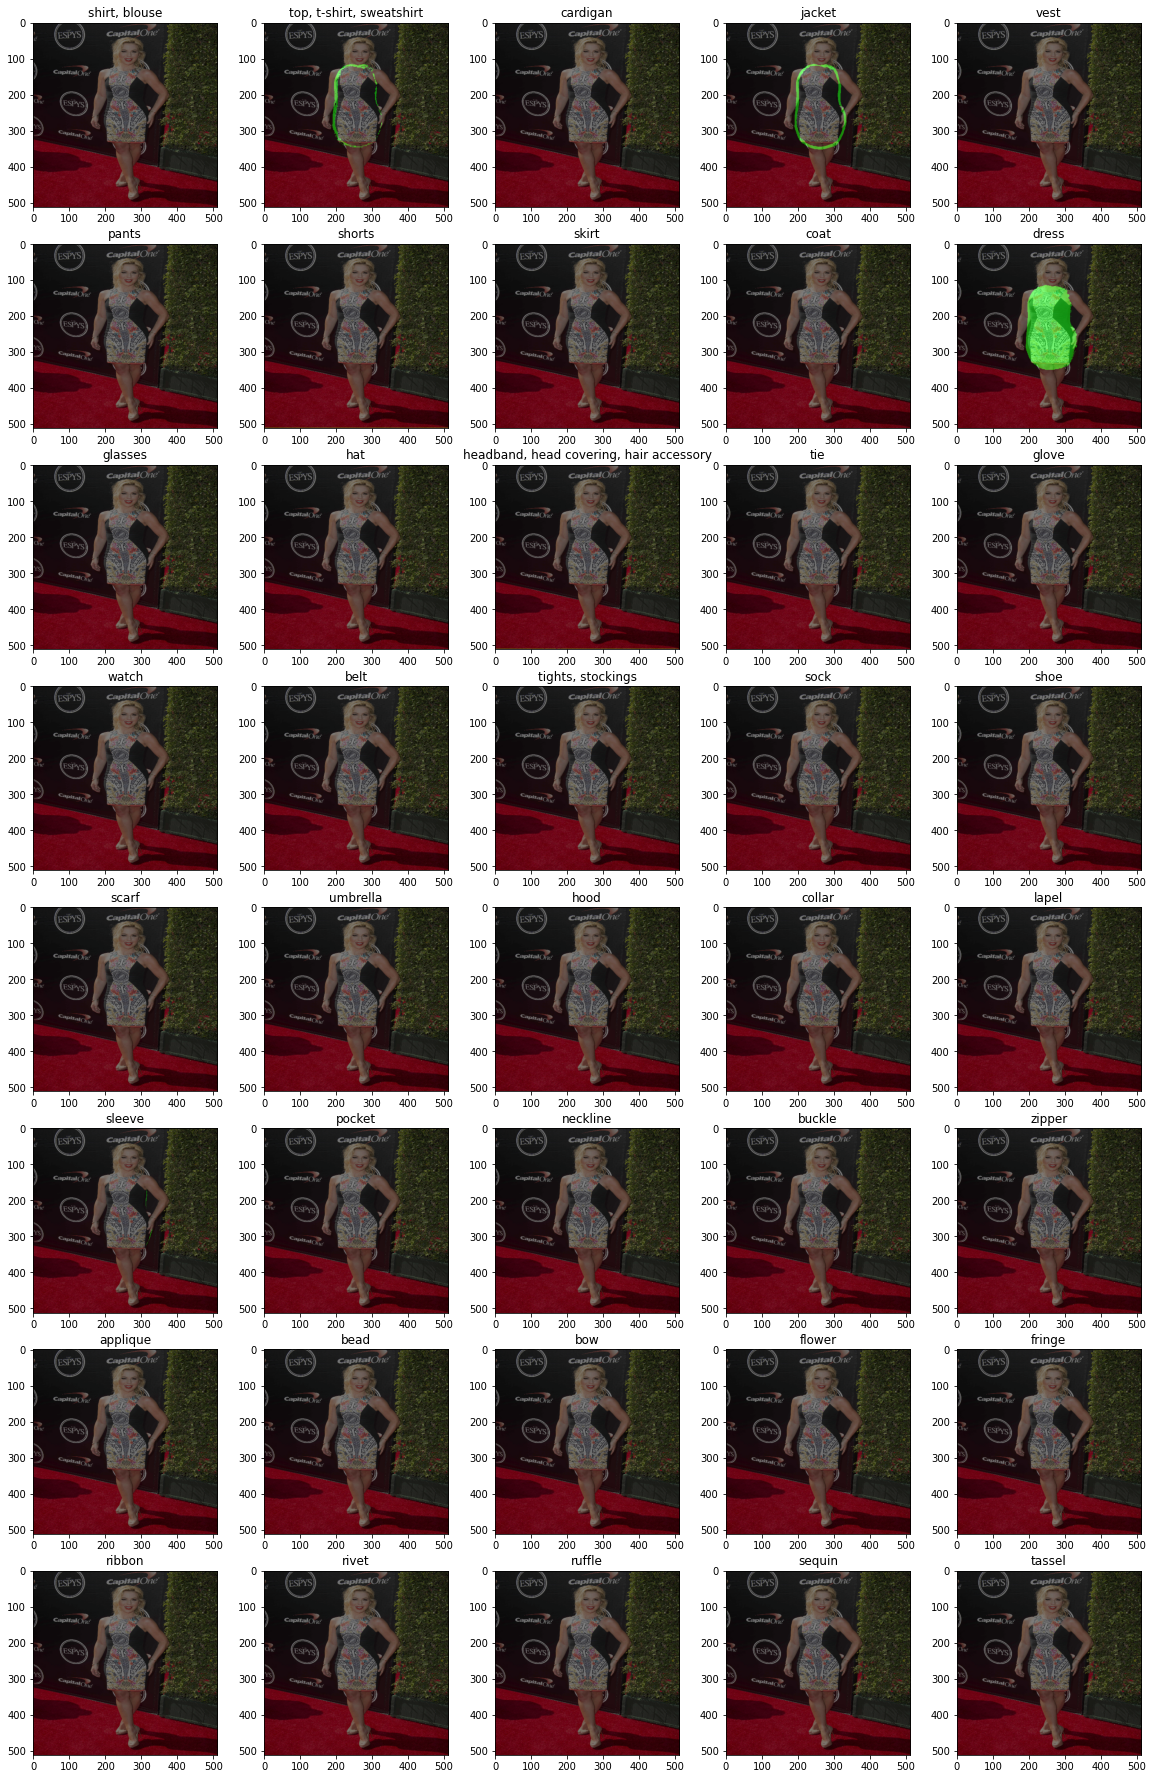

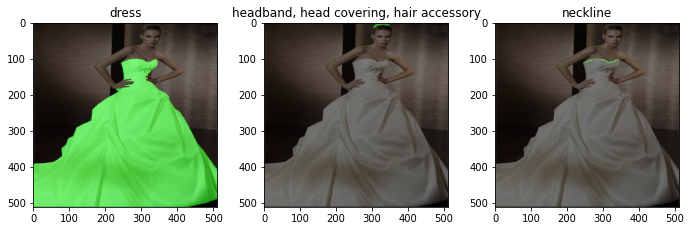

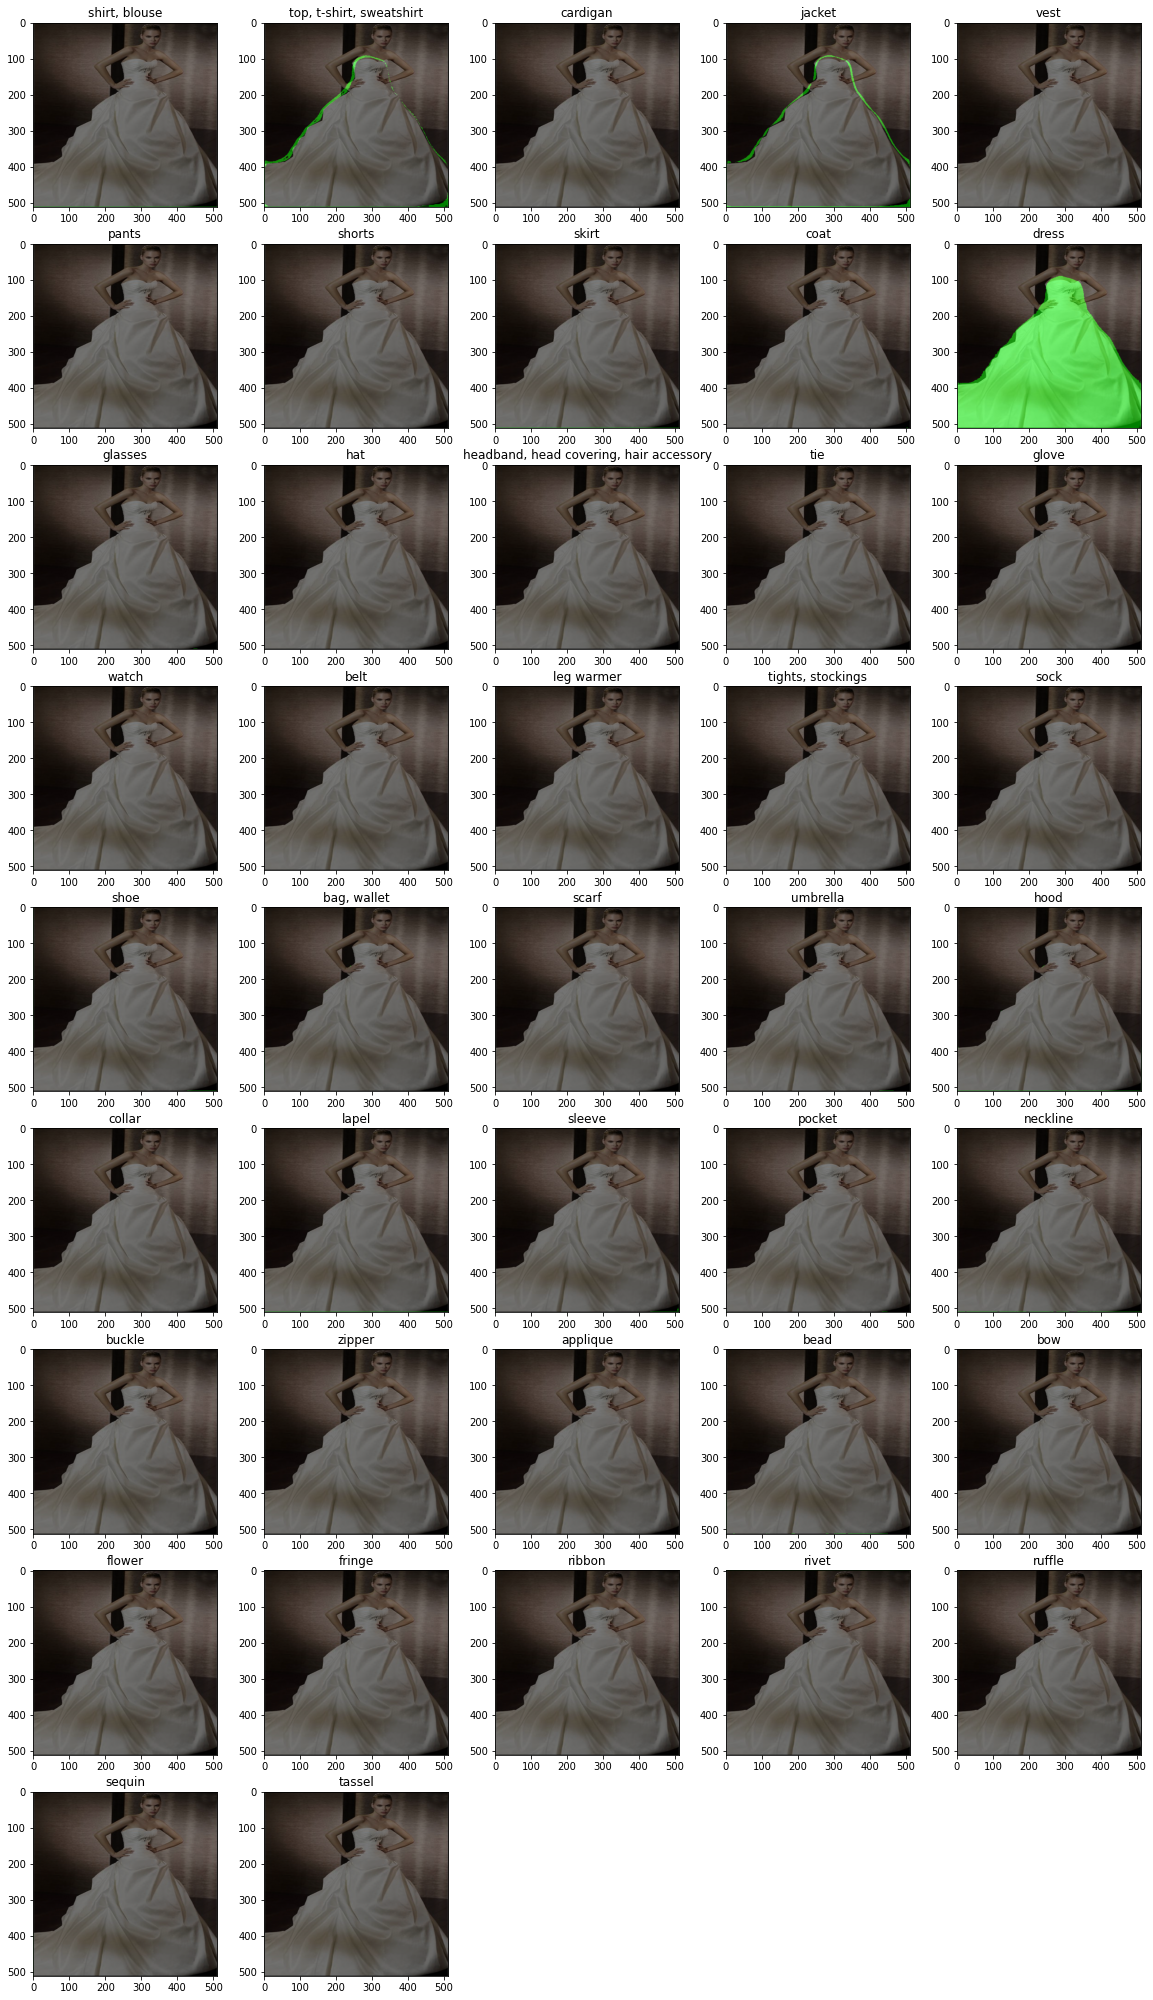

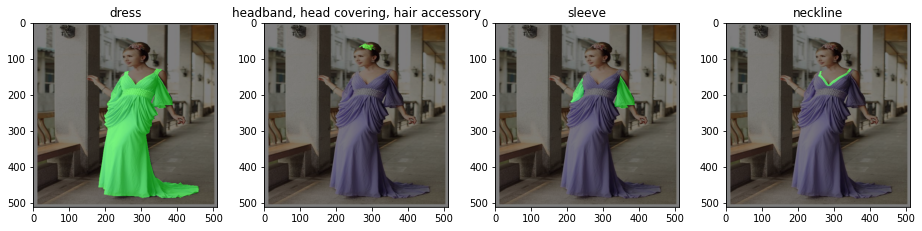

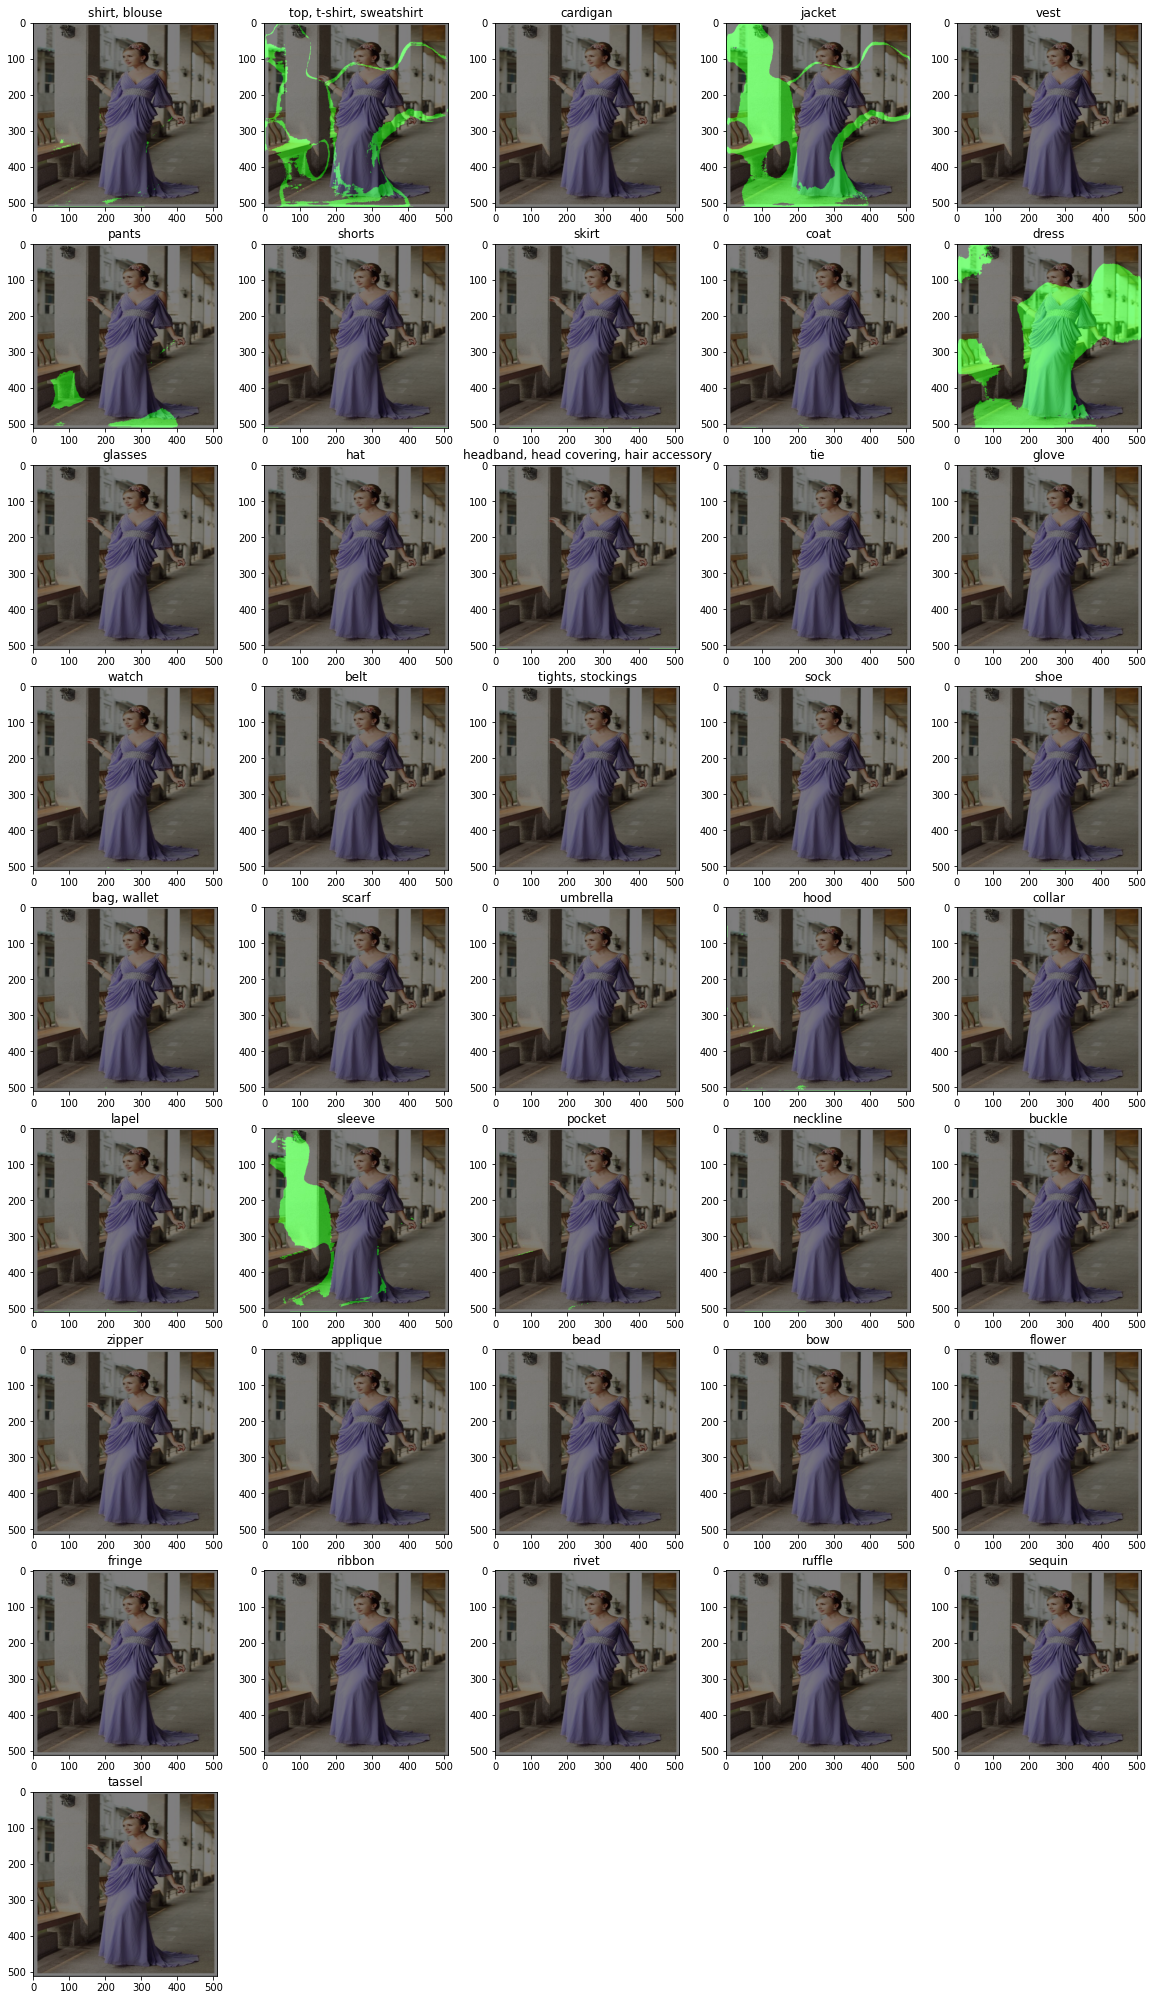

In [12]:
test_num_samples = 5
test_df = pd.read_csv("./train.csv")

class FashionDataset(torch.utils.data.Dataset):

    def __init__(self, mode, df, folder, transfrom=None, num_samples=None):
        self.mode = mode

        self.df = df
        self.names = sorted(df.ImageId.unique().tolist())[0:test_num_samples]  
       
        self.folder = folder
        self.transfrom = transfrom
        self.num_samples = num_samples

    def rle_to_mask(self, item, shape):

        mask = np.zeros((46, 512,512), dtype=int)
        for i in range(0, 46):
            channel = item[item.ClassId == str(i)]

            for j, (_, obj) in enumerate(channel.iterrows()):
                a = rle_decode(obj.EncodedPixels, shape, int)
                a = cv2.resize(a, (512,512), interpolation=cv2.INTER_NEAREST)                
                mask[i] = mask[i] + (a)
        mask = mask.astype(np.uint8)
        mask = np.transpose(mask, (1, 2, 0))
        return mask

    def __getitem__(self, idx):      

       
        name = self.names[idx]

        origin_fn = self.folder + '/' + name

       
        origin = cv2.imread(str(origin_fn))
        origin_size = origin.shape[:2]
        height = 512
        width = 512
        dim = (width, height)
        origin = cv2.resize(origin, dim, interpolation=cv2.INTER_LINEAR)

        origin = cv2.cvtColor(origin, cv2.COLOR_BGR2RGB)
       

        mask = None

        if self.mode in ["train", "val"]:            
            item = self.df[self.df.ImageId == name]
            mask = self.rle_to_mask(item, origin_size)

        if self.transfrom is not None:
            transformed = self.transfrom(
                image=origin,
                mask=mask
            )
            origin = transformed["image"]
            mask = transformed["mask"]

        if mask is None:
            return name, origin
        return name, origin, mask

    def __len__(self):
        if self.num_samples is not None:
            return self.num_samples
        return len(self.names)

datasets["test"] = FashionDataset(
    "val",
    test_df,
    train_folder,    
    A.Compose([
        A.Resize(512, 512),
        custom_to_std_tensor
    ]),
    test_num_samples,
)

segmentation_model = smp.Unet(
    encoder_name="mobilenet_v2", 
    encoder_weights="imagenet",
    classes=46,
    activation=None
)


checkpoint_fn = models_folder + '/' + "unet-mobilenet-v2-epoch-59-ckpt_saved.pt"
if checkpoint_fn is not None:
    checkpoint = torch.load(checkpoint_fn)

    if "model_state_dict" in checkpoint:
        segmentation_model.load_state_dict(checkpoint["model_state_dict"])
        print("load model_state_dict")
    else:
        segmentation_model.load_state_dict(checkpoint)
        print("load model checkpoint")

    if "epoch" in checkpoint:
        initial_epoch = checkpoint["epoch"]
        print("load initial epoch")

segmentation_model.to(device)


for i in range(0,5):
  name, image, mask = datasets["test"][i]

  images = image.unsqueeze(0)
  masks = mask.unsqueeze(0)
  images = images.to(device) 
  masks = masks.to(device)  
  with torch.no_grad():
      segmentation_model.eval()
      outs = segmentation_model(images)
      outs = outs.cpu().detach()


  probs = outs.sigmoid()

  draw(images[0].cpu(), masks[0].cpu(), label_description)
  draw(images[0].cpu(), probs[0].cpu() > 0.3, label_description)
